In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from nilearn import image as nimg
from nilearn import plotting as nplot
import bids
from nltools.file_reader import onsets_to_dm
from nltools.stats import regress, zscore
from nltools.data import Brain_Data, Design_Matrix
from nltools.stats import find_spikes 
from nilearn.plotting import view_img, glass_brain, plot_stat_map
from bids import BIDSLayout, BIDSValidator
import os
from pathlib import Path
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
from nilearn.glm.first_level import FirstLevelModel
from nilearn import plotting
from nilearn.plotting import plot_contrast_matrix
from nilearn.glm.first_level import FirstLevelModel
from nilearn import plotting
# creating mean img for plotting purposes 
from nilearn.image import mean_img
from nilearn.image import load_img
from nibabel import load
from nibabel.gifti import GiftiDataArray, GiftiImage
from nilearn.glm.first_level import run_glm as run_glm
from nilearn.glm import compute_contrast
import nilearn
fsaverage = nilearn.datasets.fetch_surf_fsaverage(mesh='fsaverage')

# Making results folder -- change to what this should actually be 
path = '/Volumes/Seagate Desktop Drive/kdata/'
os.chdir(path)
output_dir = Path.cwd() / "results" / "surface" / "first_level_results"
output_dir.mkdir(exist_ok=True, parents=True)
print(f"Output will be saved to: {output_dir}")

#isolating directory called layout_raw (for events.tsv files) -- will change depending on where data is stored / what computer we're running on
layout_raw = bids.BIDSLayout('/Volumes/Seagate Desktop Drive/kdata/', validate=True)

#isolating directory called layout (for fMRIprep derivatives) -- will change depending on where data is stored / what computer we're running on 
layout = bids.BIDSLayout('/Volumes/Seagate Desktop Drive/kdata/derivatives', validate=False,
                  config=['bids','derivatives'])
print(layout)

Output will be saved to: /Volumes/Seagate Desktop Drive/kdata/results/surface/first_level_results
BIDS Layout: ...esktop Drive/kdata/derivatives | Subjects: 58 | Sessions: 110 | Runs: 174


### Running first-level for all participants

In [3]:
# needed for making design matrix 
# note: keep MNI files for isolating tr / frames bc easier to load 
def load_bids_events(layout,layout_raw, subject, run, session):
    '''Create a design_matrix instance from BIDS event file'''
    
    tr = 2.5 #put in manually bc get_tr wouldn't work?? 
    # change lines below -- can change to "mask", change task to "self-other"
    func_files = layout.get(subject=subject,
                        datatype='func', task='selfother',session = session,
                        desc='preproc',
                        space='MNI152NLin2009cAsym',
                        extension='nii.gz',
                       return_type='file')
    func_file = nimg.load_img(func_files[run])
    n_tr = func_file.shape[-1]

    onsets = pd.read_csv(layout_raw.get(subject=subject, suffix='events', session = session)[run].path)
    # line below is isolating the onset, duration, and trial type columns -- change according to events.tsv format 
    onsets_actual = onsets.iloc[:, [0,1,3]]
    onsets_actual.columns = ['onset', 'duration','trial_type'] # make sure this order matches with what's loaded in as "onsets_actua
    sampling_freq = 1/tr
    n_scans=n_tr
    return onsets_actual, tr, n_scans

from nilearn.datasets import fetch_icbm152_brain_gm_mask
from nilearn import plotting, masking
from nilearn.masking import _unmask_3d
from nilearn.maskers import nifti_spheres_masker
import nibabel as nib
from nibabel import Nifti1Image
from nilearn.image import resample_to_img 

sess = '01'
sub = '102'
fmri_imgs = layout.get(subject=sub,
            datatype='func', task='selfother',session = sess,
            desc='preproc',
            space='MNI152NLin2009cAsym',
            extension='nii.gz',
           return_type='file')

space_defining_image = masking.compute_brain_mask(fmri_imgs[0])

icbm_mask = fetch_icbm152_brain_gm_mask()
space_defining_image = masking.compute_brain_mask(fmri_imgs[0])

icbm_mask = resample_to_img(source_img=icbm_mask, target_img=space_defining_image, interpolation='nearest')

In [4]:
subjects = layout.get_subjects()

# subjects missing ses02:
# 102, 138, 145, 209, 221, 237 
subjects2 = []
subjects2 = subjects
#subjects2 = subjects
#testing second level (removing all subs with errors) 
del(subjects2[0]) #- 102 
del(subjects2[21]) #- 138 +1
del(subjects2[25]) #- 145 +1 
del(subjects2[32]) #- 209 +1 
del(subjects2[40]) #- 221 +1 
del(subjects2[50]) #- 237 +2 

subjects = layout.get_subjects()


In [ ]:
# to iterate through subjects ... 
#for sub in subjects 
from scipy.stats import norm

p001_unc = norm.isf(0.001)

file_lists = {"self-other": list(),
    "other-fix": list(),
     "self-fix": list(),
     "case-fix": list()
    }

firstlevel_plots = {"self-other": list(),
    "other-fix": list(),
     "self-fix": list(),
     "case-fix": list()
    }

nosessions = ['01','02']

for sess in nosessions: 

    if sess == '01':
        subject_list = subjects
    elif sess == '02':
        subject_list = subjects2
    
    for sub in subject_list: 
# change lines below -- can change to "mask", change task to "self-other" -- should match the same format as in the load_bids_events function
        fmri_imgs = layout.get(subject=sub,
                    datatype='func', task='selfother',session = sess,
                    desc='preproc',
                    space='MNI152NLin2009cAsym',
                    extension='nii.gz',
                   return_type='file')
        hrf_model = "spm" #canonical hrf 
        high_pass = 0.01 # The cutoff for the drift model is 0.01 Hz.

        confound_files = layout.get(subject=sub,
                        datatype='func', task='selfother',session = sess,
                        desc='confounds',
                       extension="tsv",
                       return_type='file')

# Select confounds -- set right now to just the 6 motion parameters but can add in more/less! 
       #32 confound_vars -- REMOVING GLOBAL SIGNAL 
        confound_vars = ['trans_x','trans_x_derivative1','trans_x_derivative1_power2','trans_x_power2',
                           'trans_y','trans_y_derivative1','trans_y_derivative1_power2','trans_y_power2',
                             'trans_z','trans_z_derivative1','trans_z_derivative1_power2','trans_z_power2',
                             'rot_x','rot_x_derivative1','rot_x_derivative1_power2','rot_x_power2',
                             'rot_y','rot_y_derivative1','rot_y_derivative1_power2','rot_y_power2',
                             'rot_z','rot_z_derivative1','rot_z_derivative1_power2','rot_z_power2',
                             'csf','csf_derivative1','csf_derivative1_power2','csf_power2',
                             'white_matter','white_matter_derivative1','white_matter_derivative1_power2','white_matter_power2'
                            ]

        final_confounds = confound_vars

        design_matrices = []

        print("Creating First Level Design matrix ... ")

        for idx, img in enumerate(fmri_imgs):
# Build experimental paradigm
            run = idx
            events,tr,n_scans = load_bids_events(layout,layout_raw, sub, run, sess)
    # Define the sampling times for the design matrix
            frame_times = np.arange(n_scans) * tr
            confound_file = confound_files[run]
            confound_df = pd.read_csv(confound_file, delimiter='\t')
            confound_df = confound_df[final_confounds]
            confound_df.fillna(0, inplace=True)
    # Build design matrix with the previously defined parameters
            design_matrix = make_first_level_design_matrix(
                frame_times,
                events,
                hrf_model=hrf_model,
                drift_model="polynomial",
                drift_order=3,
                add_regs=confound_df,
                add_reg_names=confound_vars,
                high_pass=high_pass,
            )
            design_matrix = design_matrix.iloc[:,0:11] # taking out constant intercept and adding in an intercept for each individual run
# this allows average voxel to vary across runs instead of assuming its constant 
            if idx == 0:
                design_matrix['intercept1'] = 1 
                design_matrix['intercept2'] = 0
                design_matrix['intercept3'] = 0
            elif idx == 1:
                design_matrix['intercept1'] = 0
                design_matrix['intercept2'] = 1 
                design_matrix['intercept3'] = 0
            else: 
                design_matrix['intercept1'] = 0
                design_matrix['intercept2'] = 0 
                design_matrix['intercept3'] = 1
    # put the design matrices in a list
            design_matrices.append(design_matrix)
    
# can visualize the design matrix with the line below 
#plot_design_matrix(design_matrices[1])
        print("First Level Design Matrix completed")

        contrast_matrix = np.eye(design_matrix.shape[1])
        basic_contrasts = {
            column: contrast_matrix[i]
            for i, column in enumerate(design_matrix.columns)
        }

        contrasts = {
            "self-other": (basic_contrasts["self"] - basic_contrasts["other"]),
            "self-fix": (basic_contrasts["self"] - basic_contrasts["fix"]),
            "other-fix": (basic_contrasts["other"] - basic_contrasts["fix"]),
            "case-fix": (basic_contrasts["case"] - basic_contrasts["fix"]),

        }

        print("Fitting first-level GLM ...")
        #added gm mask 
        fmri_glm = FirstLevelModel(mask_img = icbm_mask)
        #no gm mask 
        #fmri_glm = FirstLevelModel()
        
        fmri_glm = fmri_glm.fit(fmri_imgs, design_matrices=design_matrices)

        print("First-level completed!")

        mean_image = mean_img(fmri_imgs[0])

        print("Subject = " + sub)

    # Iterate on contrasts
        for contrast_id, contrast_val in contrasts.items():
    #print(f"\tcontrast id: {contrast_id}")
    # compute the contrasts
            outputs = fmri_glm.compute_contrast(contrast_val, output_type='all')
    # plot the contrasts as soon as they're generated
    # the display is overlaid on the mean fMRI image
    # a threshold of 3.0 is used, more sophisticated choices are possible
            fname = "/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub" + sub + "_" + contrast_id + "_ses" + sess + ".nii.gz"
            # saving z-scores for plotting purposes  
            zname = "/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/plotting/sub" + sub + "_" + contrast_id + "_ses" + sess + ".nii.gz"
            nib.save(outputs['effect_size'], fname)
            nib.save(outputs['z_score'], zname)
            plotting.plot_glass_brain(
                outputs['z_score'],
                threshold=p001_unc,
                display_mode="z",
                title=contrast_id,
            )
            plotting.show()
            file_lists[contrast_id].append(fname)
            firstlevel_plots[contrast_id].append(zname)

### Whole-brain second-level / permutation testing

In [362]:
# subtracting ses02 - ses01 

# Dictionary to store the paths for each subject and session
subject_sessions = {}

# Populate the dictionary
for file_path in file_lists['self-other']:
    base_name = os.path.basename(file_path)
    parts = base_name.split('_')
    subject = parts[0]
    session = parts[-1].split('.')[0]
    if subject not in subject_sessions:
        subject_sessions[subject] = {}
    subject_sessions[subject][session] = file_path

# List to store the subtraction results
subtraction_results = []
postmpre_inputs = []
# Loop through each subject and perform the subtraction
for subject, sessions in subject_sessions.items():
    if 'ses01' in sessions and 'ses02' in sessions:
        # Load the NIfTI files
        ses01_img = nib.load(sessions['ses01'])
        ses02_img = nib.load(sessions['ses02'])
        
        # Extract the data
        ses01_data = ses01_img.get_fdata()
        ses02_data = ses02_img.get_fdata()
        result_data = []
        # Perform the subtraction
        result_data = ses02_data - ses01_data
        result_data = nib.Nifti1Image(result_data, ses02_img.affine, ses02_img.header)

        # Append the result to the list
        subtraction_results.append((subject, result_data))
        output_file = f'{subject}_subtraction_result.nii.gz'
        nib.save(result_data, output_file)
        postmpre_inputs.append([output_file])
        print(f'Appended result for {subject}')
    else:
        print(f'Subject {subject} does not have both ses01 and ses02 files')


Subject sub102 does not have both ses01 and ses02 files
Appended result for sub103
Appended result for sub107
Appended result for sub109
Appended result for sub110
Appended result for sub111
Appended result for sub113
Appended result for sub114
Appended result for sub115
Appended result for sub117
Appended result for sub118
Appended result for sub119
Appended result for sub120
Appended result for sub122
Appended result for sub123
Appended result for sub125
Appended result for sub126
Appended result for sub127
Appended result for sub128
Appended result for sub129
Appended result for sub132
Appended result for sub136
Subject sub138 does not have both ses01 and ses02 files
Appended result for sub139
Appended result for sub140
Appended result for sub143
Appended result for sub144
Subject sub145 does not have both ses01 and ses02 files
Appended result for sub147
Appended result for sub150
Appended result for sub202
Appended result for sub204
Appended result for sub205
Appended result for su

In [366]:
len(postmpre_inputs)

52

In [299]:
# making second-level design matrix -- version 1 

# patient group variable 
group1 = []
group2 = []
patients = []
for sub in subjects: 
    if int(sub) < 200:
        group_as = 1
    else:
        group_as = 0
    group1.append(group_as)
for sub in subjects2: 
    if int(sub) < 200:
        group_as = 1
    else:
        group_as = 0
    group2.append(group_as)
patients = np.concatenate((np.array(group1),np.array(group2)))
patients = np.expand_dims(patients, axis = -1)

group1 = []
group2 = []
controls = []
for sub in subjects: 
    if int(sub) < 200:
        group_as = 0
    else:
        group_as = 1
    group1.append(group_as)
for sub in subjects2: 
    if int(sub) < 200:
        group_as = 0
    else:
        group_as = 1
    group2.append(group_as)
controls = np.concatenate((np.array(group1),np.array(group2)))
controls = np.expand_dims(controls, axis = -1)

# session variable
post = []
session1 = np.zeros(len(subjects))
session2 = np.ones(len(subjects2))
post = np.concatenate((session1,session2))
post = np.expand_dims(post, axis = -1)

# session variable
pre = []
session1 = np.ones(len(subjects))
session2 = np.zeros(len(subjects2))
pre = np.concatenate((session1,session2))
pre = np.expand_dims(pre, axis = -1)

#subject-wise intercept
sub_matrix = np.identity(len(subjects))
sub_matrix2 = np.delete(sub_matrix, 0, axis=0)  #- 102
sub_matrix2 = np.delete(sub_matrix2, 21, axis=0)  #- 138
sub_matrix2 = np.delete(sub_matrix2, 25, axis=0)  #- 145
sub_matrix2 = np.delete(sub_matrix2, 32, axis=0)  #- 209
sub_matrix2 = np.delete(sub_matrix2, 40, axis=0)  #- 221
sub_matrix2 = np.delete(sub_matrix2, 50, axis=0)  #- 237
sub_matrix = np.concatenate((sub_matrix,sub_matrix2))

intercept = np.ones(len(post))
intercept = np.expand_dims(intercept,axis = -1)

# put all together 
second_level_design_matrix = np.hstack((patients,controls,pre,post,sub_matrix))

# delete out subs who didn't have second session ()

In [329]:
# making second-level design matrix -- version 2

# patient group variable 
group1 = []
group2 = []
patients = []
for sub in subjects: 
    if int(sub) < 200:
        group_as = 1
    else:
        group_as = -1
    group1.append(group_as)
for sub in subjects2: 
    if int(sub) < 200:
        group_as = 1
    else:
        group_as = -1
    group2.append(group_as)
patients = np.concatenate((np.array(group1),np.array(group2)))
patients = np.expand_dims(patients, axis = -1)

# session variable
post = []
session1 = np.zeros(len(subjects))
session2 = np.ones(len(subjects2))
session1 = session1-1
post = np.concatenate((session1,session2))
post = np.expand_dims(post, axis = -1)

#subject-wise intercept
sub_matrix = np.identity(len(subjects))
sub_matrix2 = np.delete(sub_matrix, 0, axis=0)  #- 102
sub_matrix2 = np.delete(sub_matrix2, 21, axis=0)  #- 138
sub_matrix2 = np.delete(sub_matrix2, 25, axis=0)  #- 145
sub_matrix2 = np.delete(sub_matrix2, 32, axis=0)  #- 209
sub_matrix2 = np.delete(sub_matrix2, 40, axis=0)  #- 221
sub_matrix2 = np.delete(sub_matrix2, 50, axis=0)  #- 237
sub_matrix = np.concatenate((sub_matrix,sub_matrix2))

intercept = np.ones(len(post))
intercept = np.expand_dims(intercept,axis = -1)
# put all together 
second_level_design_matrix = np.hstack((patients,post,sub_matrix))

# delete out subs who didn't have second session ()

In [378]:
#second level design matrix for postmpre_inputs (ses02 - ses01) 

# patient-controls group variable 
subjects = []
group1 = []
for sub in subjects2: 
    if int(sub) < 200:
        group_as = 1
    else:
        group_as = -1
    group1.append(group_as)
subjects = np.expand_dims(group1, axis = -1)


second_level_design_matrix = np.hstack((subjects))

# deleted out subs who didn't have second session (n = 5)

In [377]:
second_level_design_matrix.shape

array([[ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1]])

In [379]:
# second_level_design_matrix
# second_level_design_matrix = pd.DataFrame(second_level_design_matrix, columns=['patients'] + ['controls'] + ['pre'] + ['post'] +subjects)
# #second_level_design_matrix.to_excel("/Users/angelafang/Desktop/test.xlsx")
# second_level_design_matrix.shape


# second_level_design_matrix
# second_level_design_matrix = pd.DataFrame(second_level_design_matrix, columns=['subjects'] + ['sess'] + subjects)
# #second_level_design_matrix.to_excel("/Users/angelafang/Desktop/test.xlsx")
# second_level_design_matrix.shape

second_level_design_matrix
second_level_design_matrix = pd.DataFrame(second_level_design_matrix, columns=['group'])
#second_level_design_matrix.to_excel("/Users/angelafang/Desktop/test.xlsx")
second_level_design_matrix.shape

(52, 1)

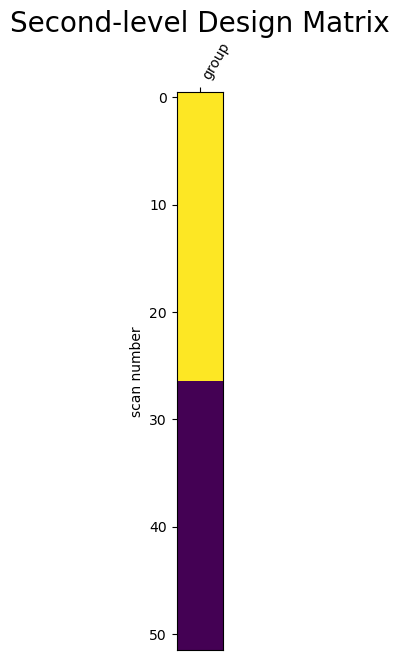

In [382]:
from nilearn.glm.second_level import SecondLevelModel 
second_level_input = postmpre_inputs
second_level_input
second_level_design_matrix
second_level_model = SecondLevelModel()
plotting.plot_design_matrix(second_level_design_matrix, rescale=False)
plt.title("Second-level Design Matrix", fontsize=20)
plotting.show()

from nilearn.glm.second_level import SecondLevelModel

second_level_model = SecondLevelModel(n_jobs=2).fit(second_level_input, design_matrix=second_level_design_matrix)

In [385]:
#Making contrasts! 
contrast_matrix = np.eye(second_level_design_matrix.shape[1])
basic_contrasts = {
    column: contrast_matrix[i]
    for i, column in enumerate(second_level_design_matrix.columns)
    }

contrasts = {
    # "intercept": (basic_contrasts['intercept'])
    #"patients-controls,post-pre": (basic_contrasts["patients"]-basic_contrasts["controls"]+basic_contrasts["post"]-basic_contrasts["pre"]),
    # "post-pre": (basic_contrasts["post"]-basic_contrasts["pre"]),
     "patients-controls": (basic_contrasts["group"]),
    }      
contrasts

# from nilearn.plotting import plot_contrast_matrix
# for key, values in contrasts.items():
#     plot_contrast_matrix(values, design_matrix=second_level_design_matrix)
#     plt.suptitle(key)
# plt.show()

{'patients-controls': array([1.])}

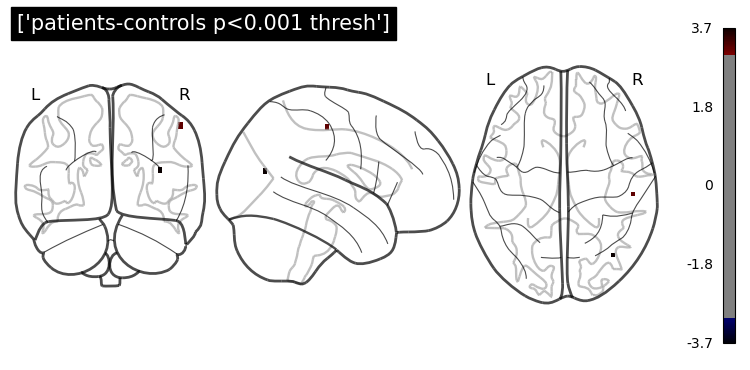

In [386]:
 # Iterate on contrasts
for contrast_id, contrast_val in contrasts.items():
    outputs = second_level_model.compute_contrast(contrast_val, output_type='all')

    fname = "/Volumes/Seagate Desktop Drive/kdata/results/second_level_results/sub" + sub + "_" + contrast_id + ".nii.gz"
    # saving z-scores for plotting purposes  
    zname = "/Volumes/Seagate Desktop Drive/kdata/results/second_level_results/plotting/sub" + sub + "_" + contrast_id + ".nii.gz"
    nib.save(outputs['effect_size'], fname)
    nib.save(outputs['z_score'], zname)
    plotting.plot_glass_brain(
        outputs['z_score'],
        threshold=p001_unc,
        display_mode="ortho",
        title=[contrast_id+" p<0.001 thresh"],
        plot_abs=False,
        colorbar=True
        )
    plotting.show()

In [387]:
# contrast_val = contrasts['patients-controls,post-pre'].T
contrast_val = contrast_val.tolist()
contrast_val

[1.0]

In [400]:
#TFCE - non-parametric cluster correction

from nilearn.glm.second_level import non_parametric_inference

out_dict = non_parametric_inference(
    second_level_input,
    design_matrix=second_level_design_matrix,
    second_level_contrast=contrast_val,
    n_perm=10000,  # 500 for the sake of time. Ideally, this should be 10,000.
    two_sided_test=True,
    smoothing_fwhm=8.0,
    tfce=True,
    #mask=dmn_avg_mask,
    threshold=0.001,
)
# ^ doesnt work bc cant make contrast_val into 1 singular value 
# basic_contrasts["patients"]-basic_contrasts["controls"]

/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/mass_univariate/permuted_least_squares.py:994: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  image.new_img_like(masker.mask_img_, metric_map),
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/masking.py:974: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


In [401]:
out_dict

{'t': <nibabel.nifti1.Nifti1Image at 0x7ff3046f8580>,
 'logp_max_t': <nibabel.nifti1.Nifti1Image at 0x7ff31a31eb50>,
 'tfce': <nibabel.nifti1.Nifti1Image at 0x7ff3046f86a0>,
 'logp_max_tfce': <nibabel.nifti1.Nifti1Image at 0x7ff3046f8070>,
 'size': <nibabel.nifti1.Nifti1Image at 0x7ff3046f86d0>,
 'logp_max_size': <nibabel.nifti1.Nifti1Image at 0x7ff3046f8e80>,
 'mass': <nibabel.nifti1.Nifti1Image at 0x7ff3046f8610>,
 'logp_max_mass': <nibabel.nifti1.Nifti1Image at 0x7ff3046f8220>}

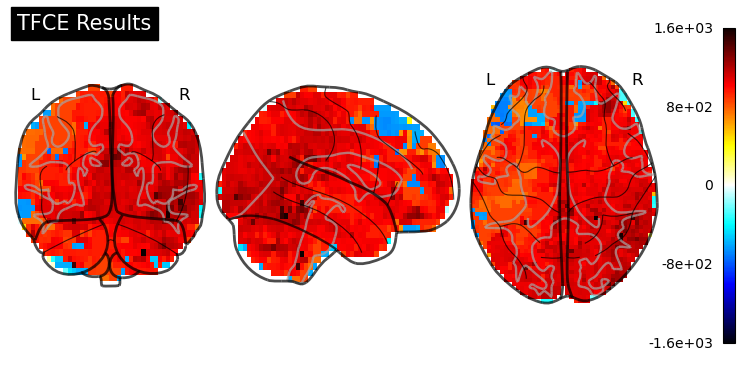

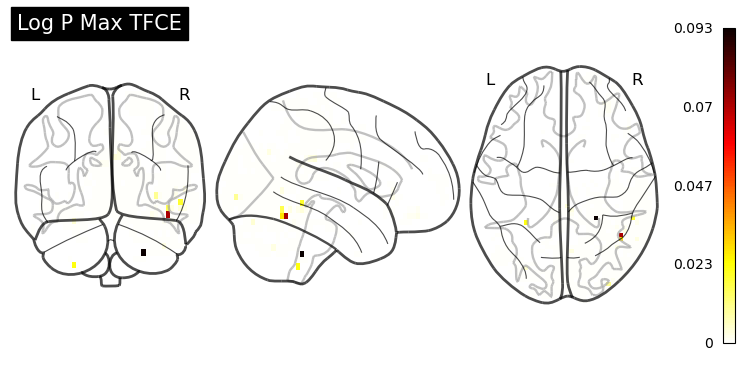

In [517]:
# Load your TFCE result NIfTI file (replace 'result_file.nii.gz' with your actual file path)
result_img = out_dict['tfce']

# Plotting the TFCE map
plotting.plot_glass_brain(result_img, threshold=0.001, title='TFCE Results', display_mode='ortho',plot_abs=False,
                       colorbar=True)

plt.show()

logp_max_tfce_img = out_dict['logp_max_tfce']

# Plotting the logp_max_tfce map
plotting.plot_glass_brain(logp_max_tfce_img, threshold=0, title='Log P Max TFCE', display_mode='ortho',plot_abs=False,
                        colorbar=True)

# Display the plot
plt.show()

# # Load your TFCE result NIfTI file (replace 'result_file.nii.gz' with your actual file path)
# result_img = out_dict['logp_max_size']

# # Plotting the TFCE map
# plotting.plot_glass_brain(result_img, threshold=0.001, title='logp max size', display_mode='ortho',plot_abs=False,
#                        colorbar=True)

# plt.show()

# logp_max_tfce_img = out_dict['logp_max_mass']

# # Plotting the logp_max_tfce map
# plotting.plot_glass_brain(logp_max_tfce_img, threshold=0, title='logp max mass', display_mode='ortho',plot_abs=False,
#                         colorbar=True)

# # Display the plot
# plt.show()

# logp_max_tfce_img = out_dict['logp_max_t']

# # Plotting the logp_max_tfce map
# plotting.plot_glass_brain(logp_max_tfce_img, threshold=0, title='logp max t', display_mode='ortho',plot_abs=False,
#                         colorbar=True)

# # Display the plot
# plt.show()

### Permutation testing with DMN mask applied -- (small volume cluster correction)

In [ ]:
# adding a DMN region mask on the image 

# creating template images for plotting / first-level masks 
from nilearn import plotting, masking
from nilearn.masking import _unmask_3d
from nilearn.maskers import nifti_spheres_masker
import nibabel as nib
from nibabel import Nifti1Image
from nilearn.image import resample_to_img 

space_defining_image = masking.compute_brain_mask(fmri_imgs[0])

from nilearn.image import resample_to_img 
# We extract data from ROIs using nilearn's NiftiLabelsMasker
from nilearn.maskers import NiftiLabelsMasker

#import DMN Neurosynth mask:
dmn_mask_raw = load_img('/Volumes/Seagate Desktop Drive/kdata/DMN masks/DMN.nii.gz')
dmn_labels = resample_to_img(source_img=dmn_mask_raw, target_img=space_defining_image, interpolation='nearest')

#average signal across DMN regions (PCC, mPFC, lTPJ, rTPJ)
dmn_data = dmn_labels.get_fdata()
binarized_data = (dmn_data > 0).astype(bool)
dmn_avg_mask = Nifti1Image(binarized_data, dmn_labels.affine, header=dmn_labels.header)


In [411]:
#TFCE - non-parametric cluster correction

from nilearn.glm.second_level import non_parametric_inference

out_dict_dmn = non_parametric_inference(
    second_level_input,
    design_matrix=second_level_design_matrix,
    second_level_contrast=contrast_val,
    n_perm=10000,  # 500 for the sake of time. Ideally, this should be 10,000.
    two_sided_test=True,
    smoothing_fwhm=8.0,
    tfce=True,
    mask=dmn_avg_mask,
    threshold=0.001,
)
# ^ doesnt work bc cant make contrast_val into 1 singular value 
# basic_contrasts["patients"]-basic_contrasts["controls"]

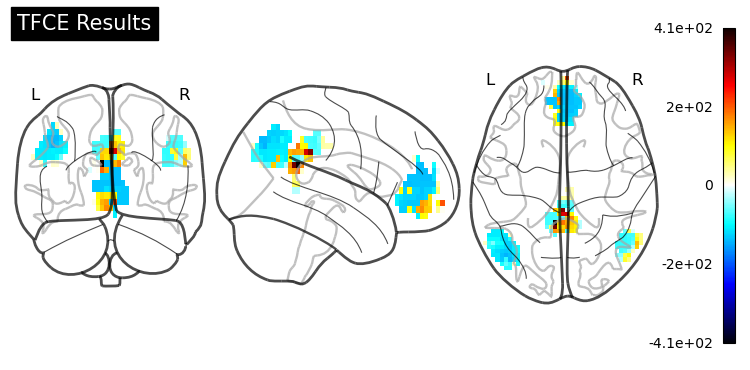

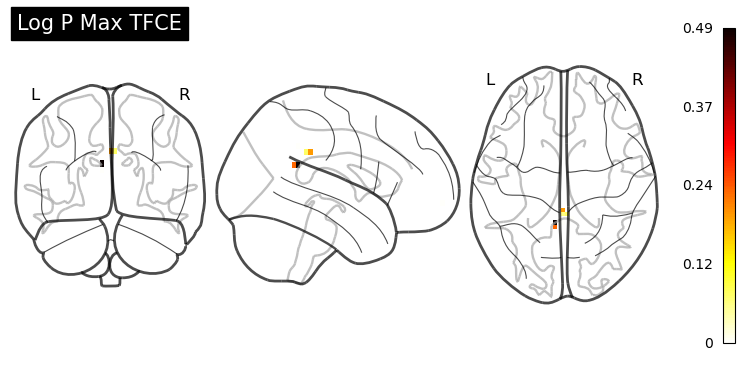

In [518]:
result_img = out_dict_dmn['tfce']

# Plotting the TFCE map
plotting.plot_glass_brain(result_img, threshold=0.001, title='TFCE Results', display_mode='ortho',plot_abs=False,
                       colorbar=True)

plt.show()

logp_max_tfce_img = out_dict_dmn['logp_max_tfce']
threshold = -np.log10(0.1)  # 10% corrected

# Plotting the logp_max_tfce map
plotting.plot_glass_brain(logp_max_tfce_img, threshold=0, title='Log P Max TFCE', display_mode='ortho',plot_abs=False,
                        colorbar=True)

# Display the plot
plt.show()

# # Load your TFCE result NIfTI file (replace 'result_file.nii.gz' with your actual file path)
# result_img = out_dict_dmn['logp_max_size']

# # Plotting the TFCE map
# plotting.plot_glass_brain(result_img, threshold=0.001, title='logp max size', display_mode='ortho',plot_abs=False,
#                        colorbar=True)

# plt.show()

# logp_max_tfce_img = out_dict_dmn['logp_max_mass']

# # Plotting the logp_max_tfce map
# plotting.plot_glass_brain(logp_max_tfce_img, threshold=0, title='logp max mass', display_mode='ortho',plot_abs=False,
#                         colorbar=True)

# # Display the plot
# plt.show()

# logp_max_tfce_img = out_dict_dmn['logp_max_t']

# # Plotting the logp_max_tfce map
# plotting.plot_glass_brain(logp_max_tfce_img, threshold=0, title='logp max t', display_mode='ortho',plot_abs=False,
#                         colorbar=True)

# # Display the plot
# plt.show()

### FDR corrections masked by DMN regions 

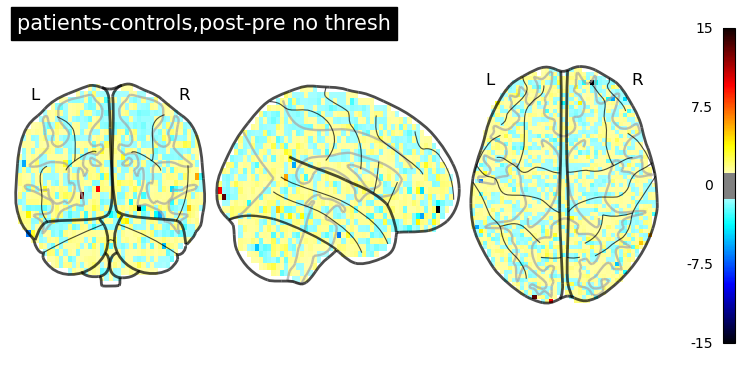

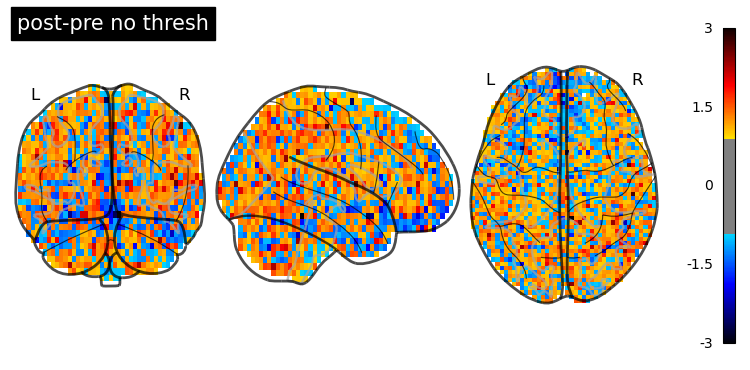

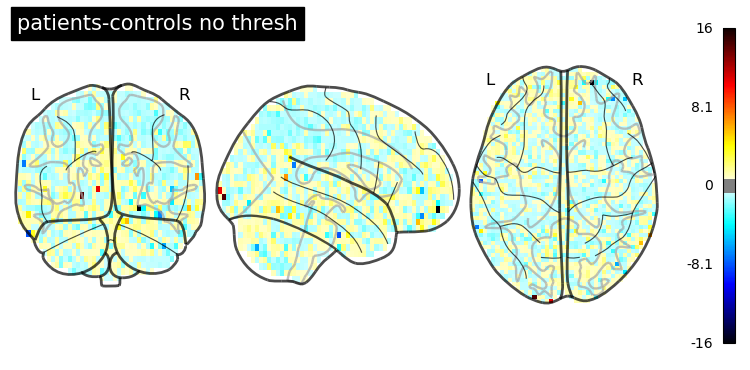

In [11]:
 # Iterate on contrasts
for contrast_id, contrast_val in contrasts.items():
    outputs = second_level_model.compute_contrast(contrast_val, output_type='all')

    fname = "/Volumes/Seagate Desktop Drive/kdata/results/second_level_results/sub" + sub + "_" + contrast_id + ".nii.gz"
    # saving z-scores for plotting purposes  
    zname = "/Volumes/Seagate Desktop Drive/kdata/results/second_level_results/plotting/sub" + sub + "_" + contrast_id + ".nii.gz"
    nib.save(outputs['effect_size'], fname)
    nib.save(outputs['z_score'], zname)
    plotting.plot_glass_brain(
        outputs['z_score'],
        display_mode="ortho",
        title=contrast_id+" no thresh",
        plot_abs=False,
        colorbar=True
        )
    plotting.show()

In [261]:
# adding a DMN region mask on the image 

# creating template images for plotting / first-level masks 
from nilearn import plotting, masking
from nilearn.masking import _unmask_3d
from nilearn.maskers import nifti_spheres_masker
import nibabel as nib
from nibabel import Nifti1Image
from nilearn.image import resample_to_img 

space_defining_image = masking.compute_brain_mask(fmri_imgs[0])

from nilearn.image import resample_to_img 
# We extract data from ROIs using nilearn's NiftiLabelsMasker
from nilearn.maskers import NiftiLabelsMasker

#import DMN Neurosynth mask:
dmn_mask_raw = load_img('/Volumes/Seagate Desktop Drive/kdata/DMN masks/DMN.nii.gz')
dmn_labels = resample_to_img(source_img=dmn_mask_raw, target_img=space_defining_image, interpolation='nearest')

#average signal across DMN regions (PCC, mPFC, lTPJ, rTPJ)
dmn_data = dmn_labels.get_fdata()
binarized_data = (dmn_data > 0).astype(bool)
dmn_avg_mask = Nifti1Image(binarized_data, dmn_labels.affine, header=dmn_labels.header)


In [84]:
import numpy as np

def fdr_threshold(p_values, alpha=0.05):
    # Sort p-values in ascending order
    sorted_indices = np.argsort(p_values)
    sorted_p_values = p_values[sorted_indices]

    # Calculate the critical value k
    num_tests = len(p_values)
    k = np.argmax(sorted_p_values > np.arange(1, num_tests + 1) * alpha / num_tests)

    # FDR threshold
    if k > 0:
        fdr_thresh = sorted_p_values[k - 1]
    else:
        fdr_thresh = 0.0

    return fdr_thresh


FDR thresh: 0.0004008540048050514
fdr z threshold: 3.3522044121351344


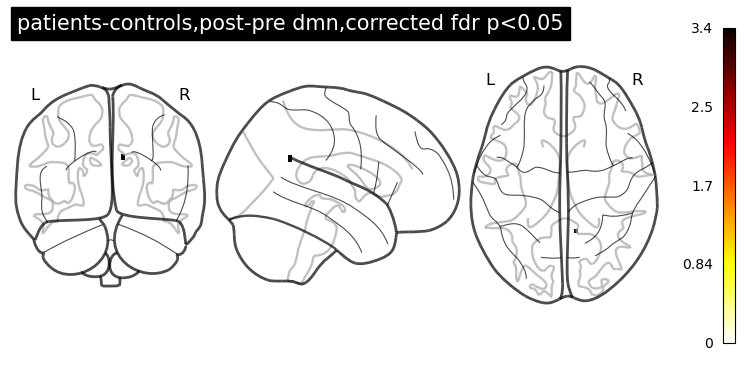

FDR thresh: 0.0
fdr z threshold: inf


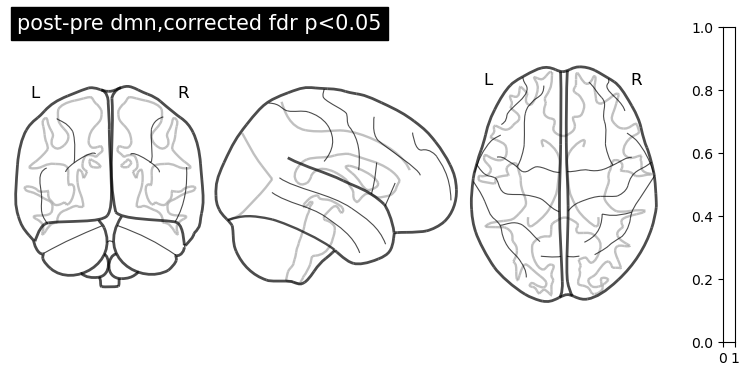

FDR thresh: 8.377722916999924e-05
fdr z threshold: 3.763495925274742


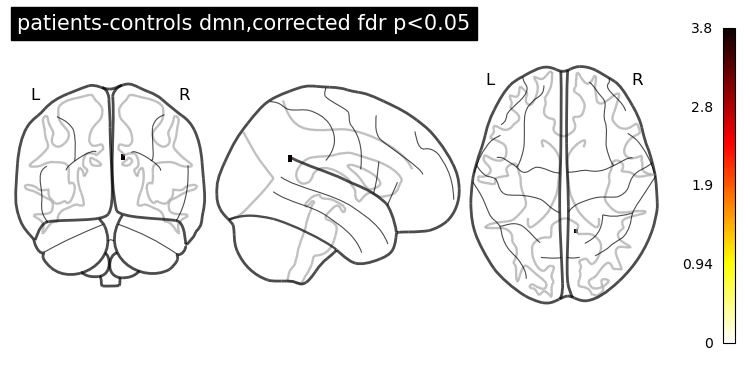

In [88]:
 # Iterate on contrasts
from nilearn.image import new_img_like

for contrast_id, contrast_val in contrasts.items():
    outputs = second_level_model.compute_contrast(contrast_val, output_type='all')
    p_values = outputs['p_value'].get_fdata()
    p_values_dmn = p_values[binarized_data]

    fdr_thresh = fdr_threshold(p_values_dmn)
    print(f"FDR thresh: {fdr_thresh}")
    fdr_z = norm.isf(fdr_thresh)
    print(f'fdr z threshold: {fdr_z}')

    z_map_raw = outputs['z_score'].get_fdata()
    z_map_thresh = z_map_raw >= fdr_z
    z_map_raw = outputs['z_score'].get_fdata()
    z_map_thresh = z_map_raw >= fdr_z
    z_map_fdr_corr = np.logical_and(z_map_thresh, binarized_data)
    z_map_img_val = z_map_raw * z_map_fdr_corr.astype(int)
    z_map_fdr_corr_img = new_img_like(outputs['z_score'], z_map_img_val)
    
    plotting.plot_glass_brain(
        z_map_fdr_corr_img,
        display_mode="ortho",
        title=contrast_id+" dmn,corrected fdr p<0.05",
        plot_abs=False,
        colorbar=True
        )
    plotting.show()

### Hypothesis 2A: Group analysis of activation from self-other task using permutation testing at baseline (with and without controlling for behavioral RTs) while including symptom change scores as a covariate

In [521]:
# subtracting ses02 - ses01 

# Dictionary to store the paths for each subject and session
subject_sessions = {}

# Populate the dictionary
for file_path in file_lists['self-other']:
    base_name = os.path.basename(file_path)
    parts = base_name.split('_')
    subject = parts[0]
    session = parts[-1].split('.')[0]
    if subject not in subject_sessions:
        subject_sessions[subject] = {}
    subject_sessions[subject][session] = file_path

# List to store just pre 
pre = []
pre_files = []
# Loop through each subject and perform the subtraction
for subject, sessions in subject_sessions.items():
    if 'ses01' in sessions:
        # Load the NIfTI files
        ses01_img = nib.load(sessions['ses01'])
        
        # Append the result to the list
        pre.append((ses01_img))
        output_file = f'{subject}_self-other_pretreatment.nii.gz'
        nib.save(ses01_img, output_file)
        pre_files.append([output_file])
        print(f'Appended result for {subject}')
    else:
        print(f'Subject {subject} does not have ses01')


Appended result for sub102
Appended result for sub103
Appended result for sub107
Appended result for sub109
Appended result for sub110
Appended result for sub111
Appended result for sub113
Appended result for sub114
Appended result for sub115
Appended result for sub117
Appended result for sub118
Appended result for sub119
Appended result for sub120
Appended result for sub122
Appended result for sub123
Appended result for sub125
Appended result for sub126
Appended result for sub127
Appended result for sub128
Appended result for sub129
Appended result for sub132
Appended result for sub136
Appended result for sub138
Appended result for sub139
Appended result for sub140
Appended result for sub143
Appended result for sub144
Appended result for sub145
Appended result for sub147
Appended result for sub150
Appended result for sub202
Appended result for sub204
Appended result for sub205
Appended result for sub206
Appended result for sub208
Appended result for sub209
Appended result for sub211
A

In [529]:
#second level design matrix for postmpre_inputs (ses02 - ses01) 
subjects = layout.get_subjects()
# patient-controls group variable 
subject_col = []
group1 = []
for sub in subjects: 
    if int(sub) < 200:
        group_as = 1
    else:
        group_as = -1
    group1.append(group_as)
subject_col = np.expand_dims(group1, axis = -1)


second_level_design_matrix = np.hstack((subject_col))

# deleted out subs who didn't have second session (n = 5)

In [532]:
second_level_design_matrix
second_level_design_matrix = pd.DataFrame(second_level_design_matrix, columns=['group'])
#second_level_design_matrix.to_excel("/Users/angelafang/Desktop/test.xlsx")
second_level_design_matrix.shape

(58, 1)

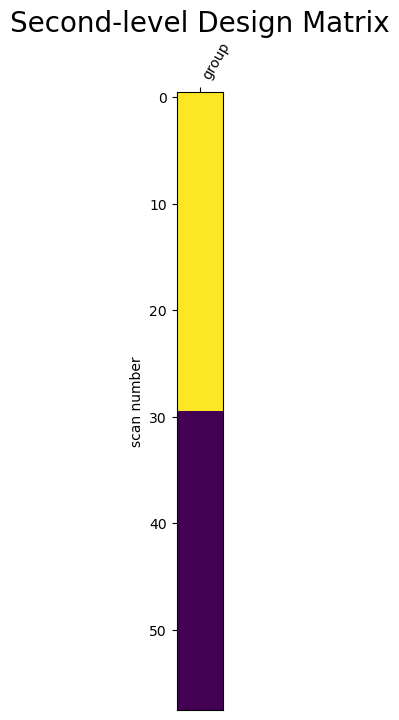

In [535]:
from nilearn.glm.second_level import SecondLevelModel 
second_level_input = pre
second_level_model = SecondLevelModel()
plotting.plot_design_matrix(second_level_design_matrix, rescale=False)
plt.title("Second-level Design Matrix", fontsize=20)
plotting.show()

from nilearn.glm.second_level import SecondLevelModel

second_level_model = SecondLevelModel(n_jobs=2).fit(second_level_input, design_matrix=second_level_design_matrix)

In [536]:
contrast_matrix = np.eye(second_level_design_matrix.shape[1])
basic_contrasts = {
    column: contrast_matrix[i]
    for i, column in enumerate(second_level_design_matrix.columns)
    }

contrasts = {
    # "intercept": (basic_contrasts['intercept'])
    #"patients-controls,post-pre": (basic_contrasts["patients"]-basic_contrasts["controls"]+basic_contrasts["post"]-basic_contrasts["pre"]),
    # "post-pre": (basic_contrasts["post"]-basic_contrasts["pre"]),
     "patients-controls": (basic_contrasts["group"]),
    }      
contrasts

{'patients-controls': array([1.])}

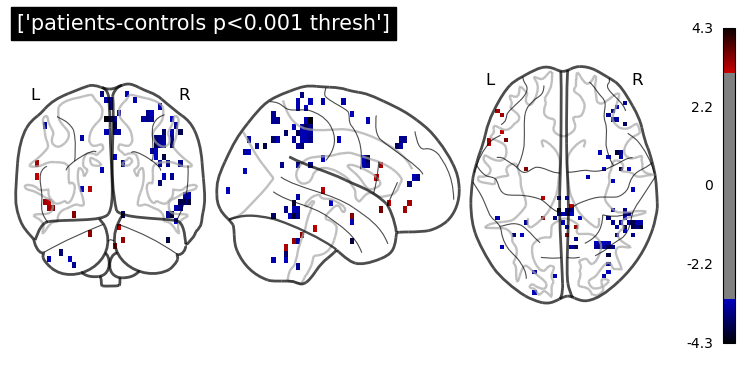

In [537]:
 # Iterate on contrasts
for contrast_id, contrast_val in contrasts.items():
    outputs = second_level_model.compute_contrast(contrast_val, output_type='all')

    fname = "/Volumes/Seagate Desktop Drive/kdata/results/second_level_results/sub" + sub + "_" + contrast_id + ".nii.gz"
    # saving z-scores for plotting purposes  
    zname = "/Volumes/Seagate Desktop Drive/kdata/results/second_level_results/plotting/sub" + sub + "_" + contrast_id + ".nii.gz"
    nib.save(outputs['effect_size'], fname)
    nib.save(outputs['z_score'], zname)
    plotting.plot_glass_brain(
        outputs['z_score'],
        threshold=p001_unc,
        display_mode="ortho",
        title=[contrast_id+" p<0.001 thresh"],
        plot_abs=False,
        colorbar=True
        )
    plotting.show()